In [25]:
# !pip install statsmodels

In [47]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gatla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
# Specify the path to the CSV file
file_path = '../Scraped_data/Barcelona_25_01.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Adding 'barcelona' column with values equal to 1
df['barcelona'] = 1

# Adding the 'event' column with values equal to 1
df['event'] = 1

# Display the DataFrame
print(df.shape)

(373, 10)


In [25]:
# Specify the path to the CSV file
file_path = '../Scraped_data/Valencia_25_01.csv'

# Read the CSV file into a DataFrame
V1 = pd.read_csv(file_path)

# Adding rows from V1 to df with 'barcelona' values set to 0 and 'event' values set to 1
df = pd.concat([df, V1.assign(barcelona=0, event=1)], ignore_index=True)

# Displaying the updated df DataFrame
print("\nUpdated df after adding rows from V1:")
print(df.shape)



Updated df after adding rows from V1:
(770, 10)


In [26]:
# Specify the path to the CSV file
file_path = '../Scraped_data/Valencia_19_24.csv'

# Read the CSV file into a DataFrame
V0 = pd.read_csv(file_path)

# Adding rows from V1 to df with 'barcelona' values set to 0 and 'event' values set to 0
df = pd.concat([df, V0.assign(barcelona=0, event=0)], ignore_index=True)

# Displaying the updated df DataFrame
print("\nUpdated df after adding rows from V1:")
print(df.shape)


Updated df after adding rows from V1:
(1167, 10)


In [27]:
# Specify the path to the CSV file
file_path = '../Scraped_data/Barcelona_19_24.csv'

# Read the CSV file into a DataFrame
B0 = pd.read_csv(file_path)

# Adding rows from B0 to df with 'barcelona' values set to 1 and 'event' values set to 0
df = pd.concat([df, B0.assign(barcelona=1, event=0)], ignore_index=True)

# Displaying the updated df DataFrame
print("\nUpdated df after adding rows from V1:")
print(df.shape)
print(df.columns)


Updated df after adding rows from V1:
(1605, 10)
Index(['Hotels', 'Ratings', 'Distance', 'District', 'Price', 'Link', 'Star',
       'Descriptions', 'barcelona', 'event'],
      dtype='object')


In [28]:
# Create a DataFrame
df = pd.DataFrame(df)
df.head()

,Hotels,Ratings,Distance,District,Price,Link,Star,Descriptions,barcelona,event
0,apartment next to park guell,"9,0","a 2,7 km del centro",NaN,€ 1.608,https://www.booking.com/hotel/es/apartment-par...,4 de 5,Apartment next to park guell se encuentra en B...,1,1
1,Melia Barcelona Sky 4* Sup,"8,2","a 3,3 km del centro",NaN,€ 3.343,https://www.booking.com/hotel/es/melia-barcelo...,4 de 5,Este hotel de diseño ocupa uno de los edificio...,1,1
2,Nice room By Eixample,"6,7","a 1,3 km del centro",NaN,€ 687,https://www.booking.com/hotel/es/nice-room-for...,5 de 5,Nice room By Eixample se encuentra en Barcelon...,1,1
3,Mercedes Heritage Apartments,"8,5","a 1,5 km del centro",NaN,€ 3.565,https://www.booking.com/hotel/es/provenza-mbs....,2 de 5,"El Mercedes Heritage Apartments, situado en l'...",1,1
4,Gran Hotel La Florida G.L Monumento,"8,7","a 5,9 km del centro",NaN,€ 1.963,https://www.booking.com/hotel/es/gran-la-flori...,4 de 5,"El Gran Hotel La Florida G.L Monumento, de 5 e...",1,1


In [32]:
# # First, count the occurrences of each value in the 'Hotels' column
# hotel_counts = df['Hotels'].value_counts()

# # Then, create a new DataFrame containing only rows with 'Hotels' values that appear twice
# df = df[df['Hotels'].isin(hotel_counts[hotel_counts == 2].index)]

# # Finally, print the count of 'Hotels' values
# print(df['Hotels'].value_counts())

In [33]:
# # Find the 'Price' value when 'Hotels' is equal to 'Ohla Barcelona'
# ohla_barcelona_price = df.loc[df['Hotels'] == 'Ohla Barcelona', 'Price'].values[0]

# # Print the 'Price' value
# print("Price for 'Hotels' == 'Ohla Barcelona':", ohla_barcelona_price)

In [29]:
# Extract only digits from the 'Price' column and convert to numeric
df['Price'] = pd.to_numeric(df['Price'].str.replace('[^\d]', '', regex=True), errors='coerce')

# Extract the first digit and convert to numeric
df['Star'] = pd.to_numeric(df['Star'].str.extract('(\d)', expand=False), errors='coerce')

# Display the updated DataFrame
df.head()

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
C:\Users\gatla\AppData\Local\Temp\ipykernel_28804\3107643229.py:2: SyntaxWarning: invalid escape sequence '\d'
  df['Price'] = pd.to_numeric(df['Price'].str.replace('[^\d]', '', regex=True), errors='coerce')
C:\Users\gatla\AppData\Local\Temp\ipykernel_28804\3107643229.py:5: SyntaxWarning: invalid escape sequence '\d'
  df['Star'] = pd.to_numeric(df['Star'].str.extract('(\d)', expand=False), errors='coerce')


,Hotels,Ratings,Distance,District,Price,Link,Star,Descriptions,barcelona,event
0,apartment next to park guell,"9,0","a 2,7 km del centro",NaN,1608,https://www.booking.com/hotel/es/apartment-par...,4,Apartment next to park guell se encuentra en B...,1,1
1,Melia Barcelona Sky 4* Sup,"8,2","a 3,3 km del centro",NaN,3343,https://www.booking.com/hotel/es/melia-barcelo...,4,Este hotel de diseño ocupa uno de los edificio...,1,1
2,Nice room By Eixample,"6,7","a 1,3 km del centro",NaN,687,https://www.booking.com/hotel/es/nice-room-for...,5,Nice room By Eixample se encuentra en Barcelon...,1,1
3,Mercedes Heritage Apartments,"8,5","a 1,5 km del centro",NaN,3565,https://www.booking.com/hotel/es/provenza-mbs....,2,"El Mercedes Heritage Apartments, situado en l'...",1,1
4,Gran Hotel La Florida G.L Monumento,"8,7","a 5,9 km del centro",NaN,1963,https://www.booking.com/hotel/es/gran-la-flori...,4,"El Gran Hotel La Florida G.L Monumento, de 5 e...",1,1


In [35]:
# # Find the 'Price' value when 'Hotels' is equal to 'Ohla Barcelona'
# ohla_barcelona_price = df.loc[df['Hotels'] == 'Ohla Barcelona', 'Price'].values[0]

# # Print the 'Price' value
# print("Price for 'Hotels' == 'Ohla Barcelona':", ohla_barcelona_price)

In [10]:
# Display the count of NaN values in each column
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1605 entries, 0 to 1604
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Hotels        1605 non-null   object 
 1   Ratings       1605 non-null   object 
 2   Distance      1605 non-null   object 
 3   District      0 non-null      float64
 4   Price         1605 non-null   int64  
 5   Link          1605 non-null   object 
 6   Star          1605 non-null   int64  
 7   Descriptions  1605 non-null   object 
 8   barcelona     1605 non-null   int64  
 9   event         1605 non-null   int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 125.5+ KB
None


In [30]:
# Group the DataFrame by 'barcelona' and 'event' columns and calculate the mean of 'Price'
result = df.groupby(['barcelona', 'event'])['Price'].mean().reset_index()

# Order the result DataFrame by the 'Star' column
# result = result.sort_values(by=['Star'])

# 'result' will now contain the average 'Price' for each combination of 'barcelona' and 'event'
print(result)

   barcelona  event        Price
0          0      0   543.413098
1          0      1   722.267003
2          1      0   742.762557
3          1      1  1857.469169


In [31]:
# Count the occurrences of each unique value in the 'Star' column
star_counts = df['Star'].value_counts()

# Print the count of values for each unique 'Star'
print(star_counts)

Star
4    846
3    528
2    139
1     49
5     43
Name: count, dtype: int64


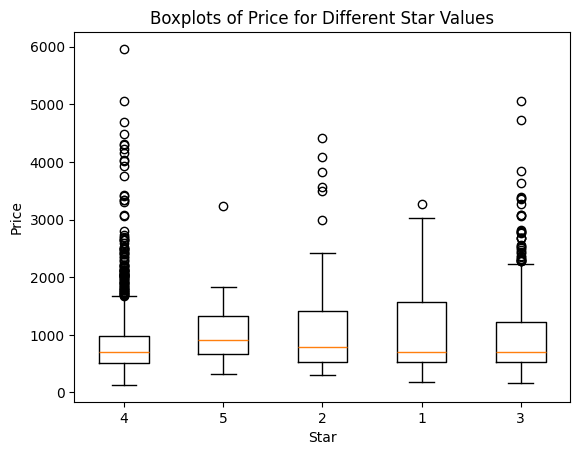

In [32]:
# Group the DataFrame by the 'Star' column and create boxplots for each group
plt.boxplot([df['Price'][df['Star'] == star] for star in df['Star'].unique()], 
            labels=df['Star'].unique())
plt.xlabel('Star')
plt.ylabel('Price')
plt.title('Boxplots of Price for Different Star Values')
plt.show()

In [14]:
# Independent variables
X = df[['barcelona']]

# Dependent variable
y = df['Price']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.575
Model:                            OLS   Adj. R-squared (uncentered):              0.574
Method:                 Least Squares   F-statistic:                              2167.
Date:                Wed, 31 Jan 2024   Prob (F-statistic):                   4.50e-300
Time:                        15:13:21   Log-Likelihood:                         -12940.
No. Observations:                1605   AIC:                                  2.588e+04
Df Residuals:                    1604   BIC:                                  2.589e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [15]:
# Independent variables
X = df[['event']]

# Dependent variable
y = df['Price']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.560
Model:                            OLS   Adj. R-squared (uncentered):              0.560
Method:                 Least Squares   F-statistic:                              2044.
Date:                Wed, 31 Jan 2024   Prob (F-statistic):                   1.84e-288
Time:                        15:13:23   Log-Likelihood:                         -12967.
No. Observations:                1605   AIC:                                  2.594e+04
Df Residuals:                    1604   BIC:                                  2.594e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [16]:
# Adding the interaction term
df['interaction_term'] = df['barcelona'] * df['event']

# Independent variables
X = df[['barcelona', 'event', 'interaction_term']]

# Dependent variable
y = df['Price']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.780
Model:                            OLS   Adj. R-squared (uncentered):              0.780
Method:                 Least Squares   F-statistic:                              1897.
Date:                Wed, 31 Jan 2024   Prob (F-statistic):                        0.00
Time:                        15:13:25   Log-Likelihood:                         -12410.
No. Observations:                1605   AIC:                                  2.483e+04
Df Residuals:                    1602   BIC:                                  2.484e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [17]:
# Adding the interaction term
df['interaction_term'] = df['barcelona'] * df['event']

# Independent variables
X = df[['barcelona', 'event', 'interaction_term']]

# Dependent variable
y = df['Price']

# Adding a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model without adding a constant term
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     592.3
Date:                Wed, 31 Jan 2024   Prob (F-statistic):          6.42e-259
Time:                        15:14:07   Log-Likelihood:                -12190.
No. Observations:                1605   AIC:                         2.439e+04
Df Residuals:                    1601   BIC:                         2.441e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              543.4131     24.173  

In [18]:
# Adding the interaction term
df['interaction_term'] = df['barcelona'] * df['event']

# Independent variables
X = df[['barcelona', 'event', 'Star', 'interaction_term']]

# Dependent variable
y = df['Price']

# Adding a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     456.2
Date:                Wed, 31 Jan 2024   Prob (F-statistic):          1.67e-262
Time:                        15:14:16   Log-Likelihood:                -12178.
No. Observations:                1605   AIC:                         2.437e+04
Df Residuals:                    1600   BIC:                         2.439e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              281.3679     59.408  

In [33]:
# Create a new column 'Top_star' based on the condition
df['Top_star'] = (df['Star'].isin([4, 5])).astype(int)


In [34]:
# Calculate the number of observations meeting the specified conditions
num_observations = df[(df['barcelona'] == 1) & (df['Top_star'] == 1) & (df['event'] == 1)].shape[0]

# Display the result
print("Number of observations:", num_observations)

Number of observations: 156


In [35]:
# Adding the interaction term
df['interaction_term'] = df['barcelona'] * df['event']

# Independent variables
X = df[['barcelona', 'event', 'Top_star', 'interaction_term']]

# Dependent variable
y = df['Price']

# Adding a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     452.0
Date:                Wed, 31 Jan 2024   Prob (F-statistic):          8.32e-261
Time:                        16:56:50   Log-Likelihood:                -12182.
No. Observations:                1605   AIC:                         2.437e+04
Df Residuals:                    1600   BIC:                         2.440e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              482.1526     28.705  

In [22]:
# Adding interaction terms
df['interaction_term'] = df['barcelona'] * df['event']
df['interaction_term_all'] = df['barcelona'] * df['event'] * df['Top_star']

# Independent variables
X = df[['barcelona', 'event', 'Top_star', 'interaction_term', 'interaction_term_all']]

# Dependent variable
y = df['Price']

# Adding a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     365.3
Date:                Wed, 31 Jan 2024   Prob (F-statistic):          2.01e-261
Time:                        15:14:33   Log-Likelihood:                -12178.
No. Observations:                1605   AIC:                         2.437e+04
Df Residuals:                    1599   BIC:                         2.440e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  508.4954 

# Processing descriptions

In [36]:
df.head()

,Hotels,Ratings,Distance,District,Price,Link,Star,Descriptions,barcelona,event,Top_star,interaction_term
0,apartment next to park guell,"9,0","a 2,7 km del centro",NaN,1608,https://www.booking.com/hotel/es/apartment-par...,4,Apartment next to park guell se encuentra en B...,1,1,1,1
1,Melia Barcelona Sky 4* Sup,"8,2","a 3,3 km del centro",NaN,3343,https://www.booking.com/hotel/es/melia-barcelo...,4,Este hotel de diseño ocupa uno de los edificio...,1,1,1,1
2,Nice room By Eixample,"6,7","a 1,3 km del centro",NaN,687,https://www.booking.com/hotel/es/nice-room-for...,5,Nice room By Eixample se encuentra en Barcelon...,1,1,1,1
3,Mercedes Heritage Apartments,"8,5","a 1,5 km del centro",NaN,3565,https://www.booking.com/hotel/es/provenza-mbs....,2,"El Mercedes Heritage Apartments, situado en l'...",1,1,0,1
4,Gran Hotel La Florida G.L Monumento,"8,7","a 5,9 km del centro",NaN,1963,https://www.booking.com/hotel/es/gran-la-flori...,4,"El Gran Hotel La Florida G.L Monumento, de 5 e...",1,1,1,1


In [37]:
def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

In [38]:
# Remove special characters
df['processed_text'] = df['Descriptions'].apply(lambda x: re.sub(r'\W', ' ', x))

# Lowercase words that are not abbreviations
df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join(abbr_or_lower(word) for word in x.split()))

# Remove stopwords
stop_words = set(stopwords.words("spanish"))
df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Apply stemming
stemmer = PorterStemmer()
df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
    

### Creating Document Term Matrix (DTM)

In [42]:
# Create document term matrix of both unigrams and bigrams using CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1,2), min_df=0.05, max_df=0.3)
X = vectorizer.fit_transform(df['processed_text'])

# Convert DTM to DataFrame
dtm_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
dtm_df

,10,10 minuto,100,100 metro,11,11 km,12,12 km,13,13 km,...,vista,vista ciudad,volver,volver aeropuerto,vía,vía satélit,wi,wi fi,zona cocina,zona comedor
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,3,2,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600,1,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1601,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1602,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1603,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,0


### Creating Term Frequency (TF)-Inverse Document Frequency (IDF) matrix

In [51]:
# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=0.05, max_df=0.40)
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])

# Convert TF-IDF to DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

tfidf_df

,10,10 minuto,100,100 metro,11,11 km,12,12 km,13,13 km,...,volver,volver aeropuerto,vía,vía satélit,wi,wi fi,wifi gratuita,zona,zona cocina,zona comedor
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.0
1,0.095747,0.104008,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.084978,0.000000,0.00000,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.114489,0.108472,0.19757,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.103240,0.000000,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600,0.123418,0.134066,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.0
1601,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.0
1602,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.184574,0.194406,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.0
1603,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.097748,0.099719,0.0,0.0,0.077782,0.073694,0.00000,0.0


### Looking for most popular words from tfidf matrix

Intuition behind this - When a term has a high sum of TF-IDF scores across hotel descriptions, it indicates that the term is not only frequently occurring within individual descriptions (high Term Frequency, TF) but also has a relatively low frequency across the entire collection of desciptions (high Inverse Document Frequency, IDF). This combination suggests that the term is both important and unique to certain hotels, so these terms are likely to be useful to include as indicator variables in the regression analysis.

In [52]:
# Get feature names and TF-IDF scores
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = X_tfidf.toarray()

# Create a DataFrame to display the top words and their TF-IDF scores
tfidf_df = pd.DataFrame(tfidf_scores, columns=feature_names)

# Display the top words and their TF-IDF scores
top_words = tfidf_df.sum(axis=0).sort_values(ascending=False)
print(top_words)

apartamento            126.806538
hotel                  122.144022
minuto pie              87.655907
playa                   75.484499
zona                    68.302574
                          ...    
cuentan air             13.705138
habitacion incluyen     13.634254
hotel ofrec             13.536668
plana vía               13.351061
servicio habitacion     13.293391
Length: 386, dtype: float64


Based on the list of words, we will include indicator variables for "terraza" and "playa", as they both have a high sum of TF-IDF scores and are most likely to be relevant for the event we are studying.

### Sentiment Analysis - Discuss with team if this should still be included?

In [48]:
df['sentiment'] = df['Descriptions'].apply(lambda x: TextBlob(x).sentiment.polarity)
df

,Hotels,Ratings,Distance,District,Price,Link,Star,Descriptions,barcelona,event,Top_star,interaction_term,processed_text,sentiment
0,apartment next to park guell,"9,0","a 2,7 km del centro",NaN,1608,https://www.booking.com/hotel/es/apartment-par...,4,Apartment next to park guell se encuentra en B...,1,1,1,1,apart next to park guell encuentra barcelona m...,0.0
1,Melia Barcelona Sky 4* Sup,"8,2","a 3,3 km del centro",NaN,3343,https://www.booking.com/hotel/es/melia-barcelo...,4,Este hotel de diseño ocupa uno de los edificio...,1,1,1,1,hotel diseño ocupa edificio alto barcelona vis...,0.0
2,Nice room By Eixample,"6,7","a 1,3 km del centro",NaN,687,https://www.booking.com/hotel/es/nice-room-for...,5,Nice room By Eixample se encuentra en Barcelon...,1,1,1,1,nice room by eixampl encuentra barcelona meno ...,0.6
3,Mercedes Heritage Apartments,"8,5","a 1,5 km del centro",NaN,3565,https://www.booking.com/hotel/es/provenza-mbs....,2,"El Mercedes Heritage Apartments, situado en l'...",1,1,0,1,merced heritag apart situado l eixampl centro ...,0.0
4,Gran Hotel La Florida G.L Monumento,"8,7","a 5,9 km del centro",NaN,1963,https://www.booking.com/hotel/es/gran-la-flori...,4,"El Gran Hotel La Florida G.L Monumento, de 5 e...",1,1,1,1,gran hotel florida g l monumento 5 estrella en...,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600,Casp Green House,"7,7","a 0,6 km del centro",NaN,610,https://www.booking.com/hotel/es/casp-er.es.ht...,4,El Casp Green House ofrece aire acondicionado ...,1,0,1,0,casp green hous ofrec air acondicionado centro...,-0.2
1601,Nice room close to Sagrada Familia,"7,1","a 1,5 km del centro",NaN,416,https://www.booking.com/hotel/es/nice-room-clo...,4,Nice room close to Sagrada Familia está en Bar...,1,0,1,0,nice room close to sagrada familia barcelona 1...,0.6
1602,The best room in the Gothic quarter with suite...,"9,2",a 400 m del centro,NaN,741,https://www.booking.com/hotel/es/best-location...,5,The best room in the Gothic quarter with suite...,1,0,1,0,the best room in the gothic quarter with suit ...,1.0
1603,Hotel Best 4 Barcelona,"7,9","a 2,7 km del centro",NaN,453,https://www.booking.com/hotel/es/4-barcelona.e...,1,Este hotel elegante cuenta con gimnasio y WiFi...,1,0,0,0,hotel elegant cuenta gimnasio wifi gratuita ub...,0.0


### Final regressions with added features

In [56]:
# Creating dummy variables for "playa" and "plaza"
df['playa'] = df['processed_text'].apply(lambda x: 1 if 'playa' in x else 0)
df['terraza'] = df['processed_text'].apply(lambda x: 1 if 'terraza' in x else 0)

In [57]:
# Independent variables
X = df[['barcelona', 'event', 'Top_star', 'interaction_term', 'playa', 'terraza']]

# Dependent variable
y = df['Price']

# Adding a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     311.0
Date:                Wed, 31 Jan 2024   Prob (F-statistic):          3.34e-264
Time:                        18:58:35   Log-Likelihood:                -12168.
No. Observations:                1605   AIC:                         2.435e+04
Df Residuals:                    1598   BIC:                         2.439e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              470.4365     30.989  